鈴木讓「統計的機械学習の数理 with Python 100問」(共立出版)

# 第9章 教師なし学習

## 9.1 K-meansクラスタリング

In [1]:
! pip install japanize_matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import japanize_matplotlib
from numpy.random import randn

In [3]:
# Anacondaの場合は下記( import japanize_matplotlib はコメントアウト)
import matplotlib
from matplotlib import font_manager
matplotlib.rc("font", family="BIZ UDGothic")

In [4]:
def k_means(X, K, iteration=20):
    n, p = X.shape
    center = np.zeros((K, p))
    y = np.random.choice(K, n, replace=True)
    scores = []

    for h in range(iteration):
        for k in range(K):
            if np.sum(y == k) == 0:
                center[k, 0] = np.inf
            else:
                for j in range(p):
                    center[k, j] = np.mean(X[y == k, j])

        S_total = 0
        for i in range(n):
            S_min = np.inf
            for k in range(K):
                S = np.sum((X[i,] - center[k,]) ** 2)
                if S < S_min:
                    S_min = S
                    y[i] = k
            S_total += S_min
        scores.append(S_total)

    return {'clusters': y, 'scores': scores}

Text(0, 0.5, '第2成分')

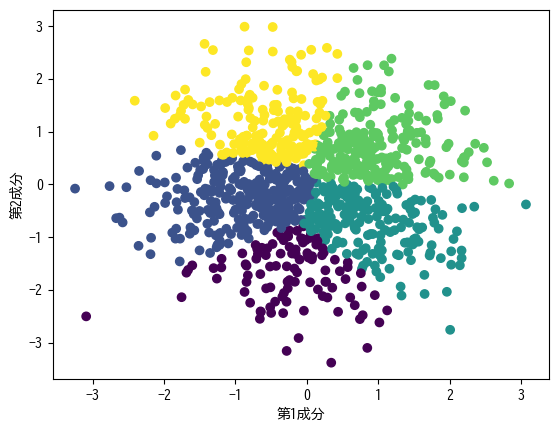

In [5]:
n = 1000
K = 5
p = 2
X = randn(n, p)  # データ生成

y = k_means(X, 5)['clusters']  # 各サンプルのクラスタを得る

# クラスタごとに色を変えて、点を書く
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("第1成分")
plt.ylabel("第2成分")

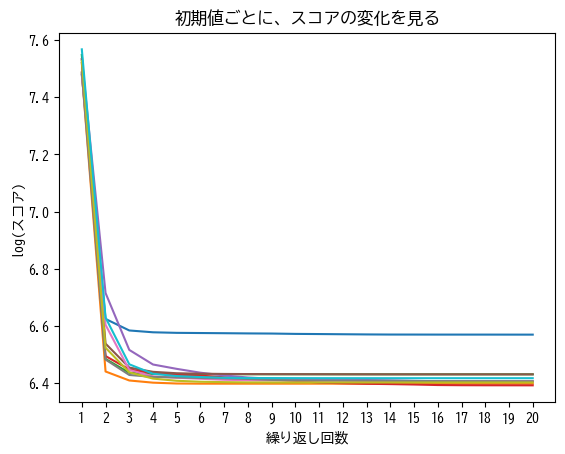

In [6]:
n = 1000
p = 2
X = randn(n, p)
itr = np.arange(1, 21, 1)

for r in range(10):
    scores = k_means(X, 5)['scores']
    plt.plot(itr, np.log(scores))

plt.xlabel("繰り返し回数")
plt.ylabel("log(スコア)")
plt.title("初期値ごとに、スコアの変化を見る")
plt.xticks(np.arange(1, 21, 1))
plt.show()

## 9.2 階層的クラスタリング

In [7]:
def dist_complete(x, y):
    return np.max(np.linalg.norm(x[:, None, :] - y[None, :, :], axis=2))

In [8]:
def dist_single(x, y):
    return np.min(np.linalg.norm(x[:, None, :] - y[None, :, :], axis=2))

In [9]:
def dist_centroid(x, y):
    x_bar = np.mean(x, axis=0)
    y_bar = np.mean(y, axis=0)
    return np.linalg.norm(x_bar - y_bar)

In [10]:
def dist_average(x, y):
    r, s = x.shape[0], y.shape[0]
    return np.sum(np.linalg.norm(x[:, None, :] - y[None, :, :], axis=2)) / (r * s)

In [11]:
import copy

In [12]:
def hc(X, dd="complete"):
    n = X.shape[0]
    index = [[i] for i in range(n)]
    cluster = [[] for _ in range(n - 1)]
    for k in range(n, 1, -1):
        dist_min = np.inf
        for i in range(k - 1):
            for j in range(i + 1, k):
                i_0, j_0 = index[i], index[j]
                x, y = X[i_0, :], X[j_0, :]
                if dd == "complete":
                    d = dist_complete(x, y)
                elif dd == "single":
                    d = dist_single(x, y)
                elif dd == "centroid":
                    d = dist_centroid(x, y)
                elif dd == "average":
                    d = dist_average(x, y)
                if d < dist_min:
                    dist_min, i_1, j_1 = d, i, j
        index[i_1].extend(index[j_1])
        if j_1 < k:
            index[j_1:k-1] = index[j_1+1:k]
        index = index[:k-1]
        cluster[k - 2] = copy.deepcopy(index)
    return cluster

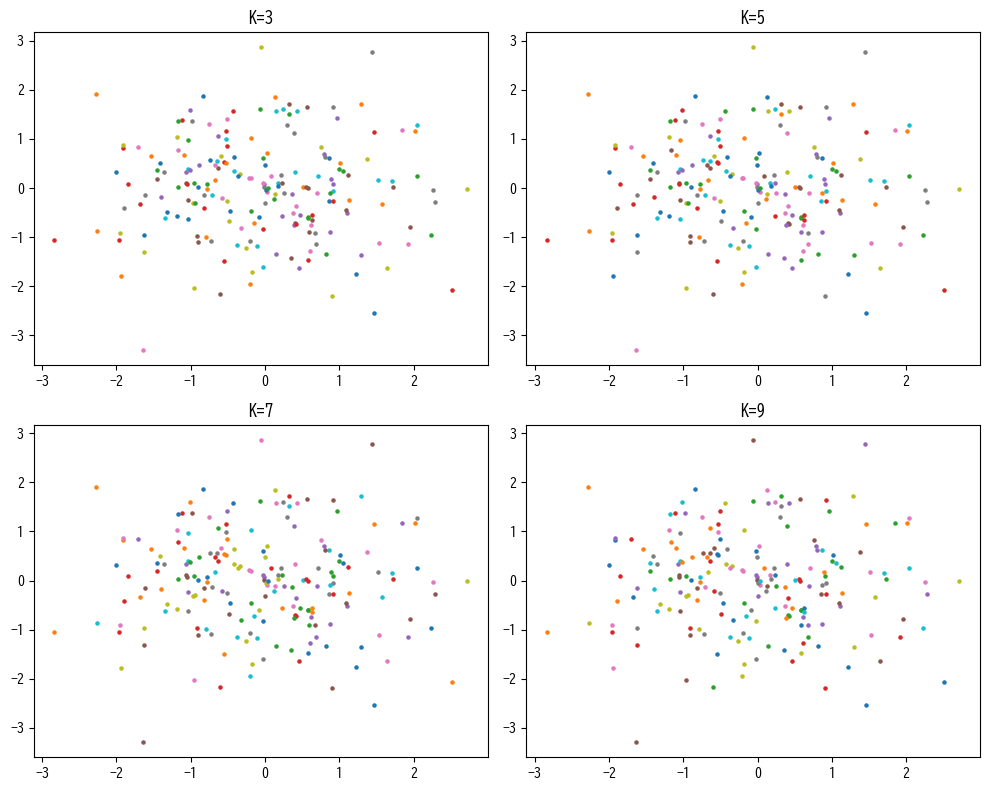

In [13]:
n = 200
p = 2
X = randn(n, p)
cluster = hc(X, "complete")

plt.figure(figsize=(10, 8)) # 図のサイズを大きくする
for i, k in enumerate([2, 4, 6, 8]):
    grp = cluster[-k]  # クラスタ数に基づく結果を取得
    plt.subplot(2, 2, i + 1)
    for g in grp:
        plt.scatter(X[g, 0], X[g, 1], s=5)
    plt.title(f"K={k + 1}")  # 実際のクラスタ数を表示
    plt.tight_layout()

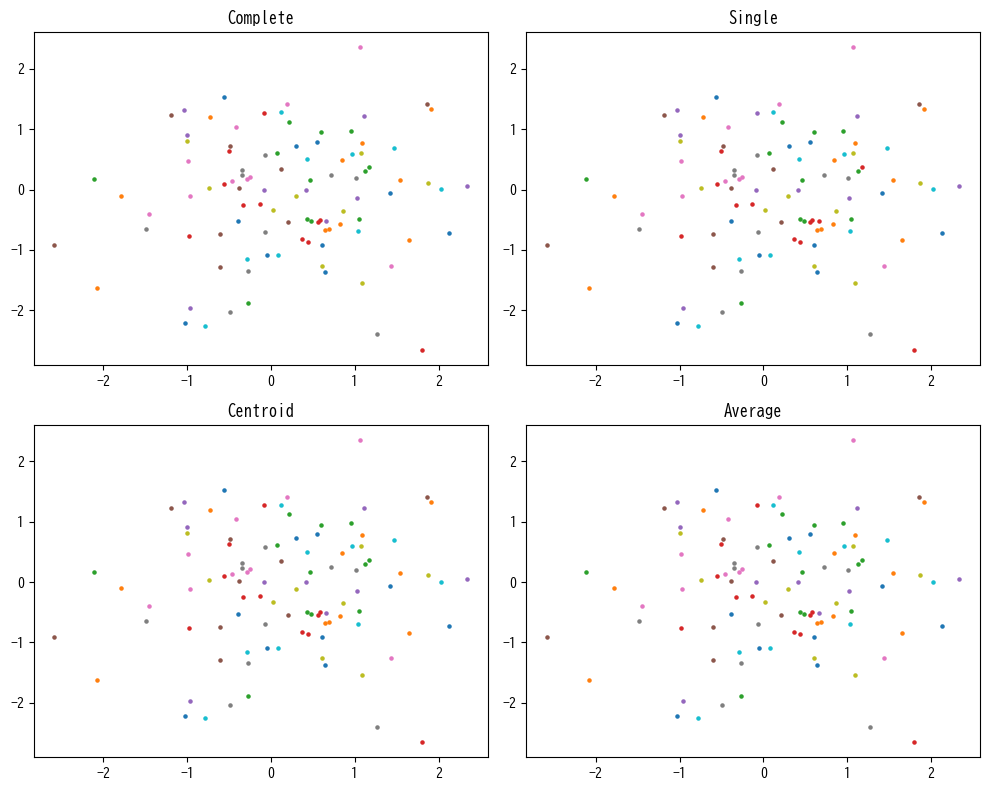

In [14]:
n = 100
p = 2
K = 7
X = randn(n, p)
plt.figure(figsize=(10, 8)) # 新しい図のサイズを設定
for i, d in enumerate(["complete", "single", "centroid", "average"], 1):
    cluster = hc(X, dd=d)
    plt.subplot(2, 2, i)
    grp = cluster[-K]
    for g in grp:
        plt.scatter(X[g, 0], X[g, 1], s=5)
    plt.title(d.capitalize())  # 距離測度名をタイトルに
    plt.tight_layout()

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram

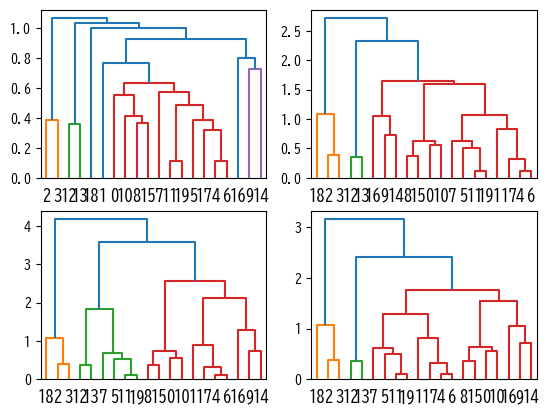

In [16]:
X = np.random.randn(20, 2)

# クラスタリングと可視化のループ
i = 1
for d in ["single", "average", "complete", "weighted"]:
    res_hc = linkage(X, method=d)
    plt.subplot(2, 2, i)
    dendrogram(res_hc)
    i += 1

plt.show()  # 全てのサブプロットを表示

### 樹形図のプログラム(付録)

In [17]:
import matplotlib.collections as mc

In [18]:
def unlist(x):
    """Flatten a list of lists."""
    y = []
    for z in x:
        y.extend(z)
    return y

In [19]:
def hc_dendrogram(cluster, dd="complete", col="black"):
    """Draw dendrogram for hierarchical clustering."""
    y = unlist(cluster[0])
    n = len(y)
    z = np.zeros([n, 5])
    index = [[y[i]] for i in range(n)]
    height = np.zeros(n)

    for k in range(n - 1, 0, -1):
        dist_min = np.inf
        for i in range(k):
            i_0 = index[i]
            j_0 = index[i + 1]
            if dd == "complete":
                d = dist_complete(X[i_0, ], X[j_0, ])
            elif dd == "single":
                d = dist_single(X[i_0, ], X[j_0, ])
            elif dd == "centroid":
                d = dist_centroid(X[i_0, ], X[j_0, ])
            elif dd == "average":
                d = dist_average(X[i_0, ], X[j_0, ])
            if d < dist_min:
                dist_min = d
                i_1 = i  # 結合されるリストの添字
                j_1 = i + 1  # 新たに結合するリストの添字

        # ここで線分の位置を計算する
        i = 0
        for h in range(i_1):
            i += len(index[h])
        mid_i_1 = i + len(index[i_1]) / 2
        mid_j_1 = i + len(index[i_1]) + len(index[j_1]) / 2
        z[k, 0] = mid_i_1
        z[k, 1] = mid_j_1
        z[k, 2] = height[i_1]
        z[k, 3] = height[j_1]
        z[k, 4] = dist_min
        index[i_1].extend(index[j_1])

        # 必要なら残りの添字を移動させる
        if j_1 < k:
            for h in range(j_1, k):
                index[h] = index[h + 1]
                height[h] = height[h + 1]
        height[i_1] = dist_min
        height[k] = 0

    # デンドログラムを描く
    lines = [[(z[k, 0], z[k, 4]), (z[k, 0], z[k, 2])] for k in range(1, n)]  # 垂直線 (左)
    lines2 = [[(z[k, 0], z[k, 4]), (z[k, 1], z[k, 4])] for k in range(1, n)]  # 水平線 (中央)
    lines3 = [[(z[k, 1], z[k, 4]), (z[k, 1], z[k, 3])] for k in range(1, n)]  # 垂直線 (右)
    lines.extend(lines2)
    lines.extend(lines3)
    lc = mc.LineCollection(lines, colors=col, linewidths=1)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.add_collection(lc)
    ax.autoscale()
    plt.show()

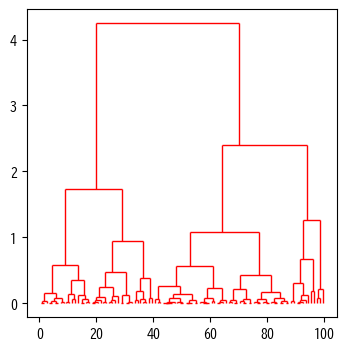

In [20]:
n = 100
p = 1
X = np.random.randn(n, p)  # numpyのrandom.randn関数を使用してランダムデータを生成
cluster = hc(X, dd="complete")
hc_dendrogram(cluster, col="red")

## 9.3 主成分分析

In [21]:
from sklearn.cluster import KMeans
import pandas as pd

In [22]:
# PCA関数の定義
def pca(X):
    n, p = X.shape
    center = np.mean(X, axis=0)
    X = X - center  # 列ごとに中心化
    Sigma = X.T @ X / n
    lam, phi = np.linalg.eig(Sigma)  # 固有値, 固有ベクトル
    index = np.argsort(-lam)  # 降順にソート
    lam = lam[index]
    phi = phi[:, index]
    return {'lam': lam, 'vectors': phi, 'centers': center}

In [23]:
# PCAの実行と結果の表示
X = np.random.randn(100, 5)
res = pca(X)

In [24]:
print(res['lam'])

[1.32924567 1.25020863 1.00824397 0.8912839  0.69273859]


In [25]:
print(res['lam'] / np.sum(res['lam']))  # 各主成分の寄与率

[0.25702193 0.24173939 0.19495329 0.17233798 0.13394741]


In [26]:
print(res['vectors'])

[[-0.31580259  0.16366568 -0.62241247 -0.07655788 -0.69298187]
 [ 0.75973009 -0.1065019   0.1379014   0.33110092 -0.53181098]
 [-0.29701649 -0.80446568 -0.13423683  0.49646137  0.01107936]
 [-0.0150815  -0.50921234  0.30441097 -0.74504601 -0.3044926 ]
 [ 0.48438896 -0.23539042 -0.69491032 -0.28799934  0.37962443]]


In [27]:
print(res['centers'])

[-0.1539149   0.2218577   0.0555753   0.11432762 -0.13100162]


In [28]:
from sklearn.decomposition import PCA

In [29]:
# sklearnのPCAを用いた例
pca = PCA()
pca.fit(X)

PCA()

In [30]:
score = pca.transform(X)  # 主成分得点
print(score[:5, ])

[[-1.8513407  -1.34686846 -1.61458309 -0.8135489  -0.49052459]
 [-0.42421234 -1.81096792  0.5044578  -1.19043728 -0.58932446]
 [ 2.0904078   2.39581709  0.94943732 -1.23392897 -1.56813888]
 [-0.52237244  0.00758373 -1.23716269  0.56994826  1.25920798]
 [-1.60075156  1.66698269  0.67408661  0.32322216 -0.52844394]]


In [31]:
print(pca.components_)  # 主成分負荷量
print(pca.mean_)  # 中心
print(pca.explained_variance_ratio_)  # 寄与率

[[ 0.31580259 -0.75973009  0.29701649  0.0150815  -0.48438896]
 [ 0.16366568 -0.1065019  -0.80446568 -0.50921234 -0.23539042]
 [-0.62241247  0.1379014  -0.13423683  0.30441097 -0.69491032]
 [ 0.07655788 -0.33110092 -0.49646137  0.74504601  0.28799934]
 [ 0.69298187  0.53181098 -0.01107936  0.3044926  -0.37962443]]
[-0.1539149   0.2218577   0.0555753   0.11432762 -0.13100162]
[0.25702193 0.24173939 0.19495329 0.17233798 0.13394741]


Text(0, 0.5, '寄与率')

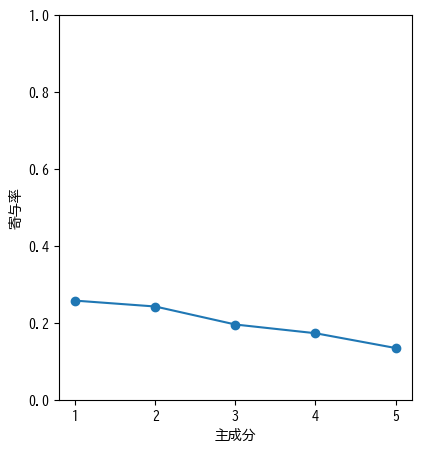

In [32]:
# 寄与率のプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 6), pca.explained_variance_ratio_)
plt.scatter(np.arange(1, 6), pca.explained_variance_ratio_)
plt.xticks(np.arange(1, 6))
plt.ylim(0, 1)
plt.xlabel("主成分")
plt.ylabel("寄与率")

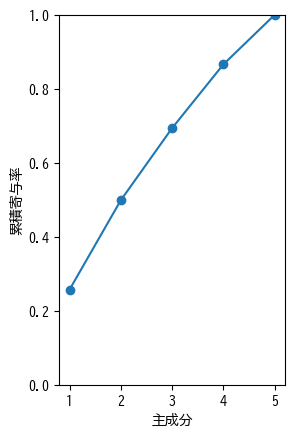

In [33]:
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 6), np.cumsum(pca.explained_variance_ratio_))
plt.scatter(np.arange(1, 6), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(1, 6))
plt.ylim(0, 1)
plt.xlabel("主成分")
plt.ylabel("累積寄与率")
plt.show()

(-4.0, 4.0)

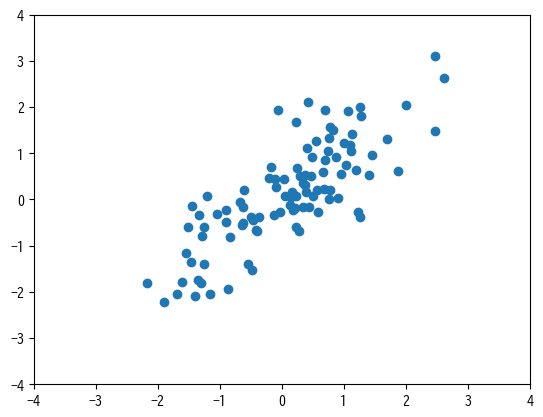

In [34]:
# パラメータの設定
n = 100
a = 0.7
b = np.sqrt(1 - a**2)

# データ生成
u = np.random.randn(n)
v = np.random.randn(n)
x = u
y = a * u + b * v

# データのプロット
plt.scatter(x, y)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [35]:
# データの結合
D = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)

# PCAの実行
pca = PCA(n_components=2)
pca.fit(D)

PCA(n_components=2)

In [36]:
# 主成分ベクトル(主成分負荷量)の取得
T = pca.components_

# 主成分ベクトルが直交していることの確認
T[0, 1] / T[0, 0] * T[1, 1] / T[1, 0]

-1.0

In [37]:
# 直線の定義
def f_1(x):
    return T[0, 1] / T[0, 0] * x

def f_2(x):
    return T[1, 1] / T[1, 0] * x

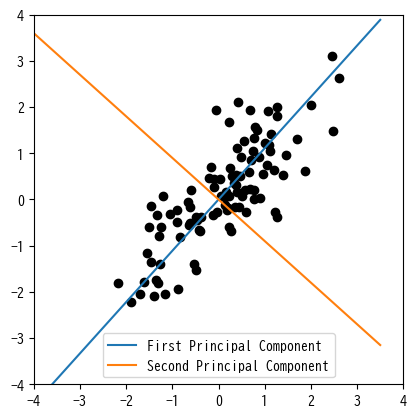

In [38]:
# 直線のプロット
x_seq = np.arange(-4, 4, 0.5)

plt.scatter(x, y, c="black")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.plot(x_seq, f_1(x_seq), label='First Principal Component')
plt.plot(x_seq, f_2(x_seq), label='Second Principal Component')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

In [39]:
import pandas as pd

# USAデータの読み込みと標準化
usa = pd.read_csv('USArrests.csv', header=0, index_col=0)
X = (usa - np.average(usa, 0)) / np.std(usa, 0)
index = usa.index
col = usa.columns

# PCAの適用
pca = PCA(n_components=2)
pca.fit(X)
score = pca.fit_transform(X)
vector = pca.components_
vector

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864]])

In [40]:
# PCAの結果の確認
vector.shape[1]
evr = pca.explained_variance_ratio_
evr

array([0.62006039, 0.24744129])

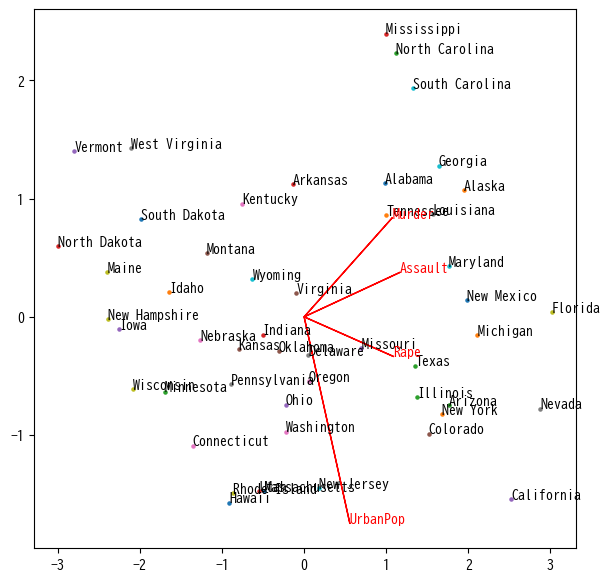

In [41]:
# PCA結果のプロット
plt.figure(figsize=(7, 7))
for i in range(score.shape[0]):
    plt.scatter(score[i, 0], score[i, 1], s=5)
    plt.annotate(index[i], xy=(score[i, 0], score[i, 1]))
for j in range(vector.shape[1]):
    # 2は線の長さ、任意で良い
    plt.arrow(0, 0, vector[0, j] * 2, vector[1, j] * 2, color="red")
    plt.text(vector[0, j] * 2, vector[1, j] * 2, col[j], color="red")

In [42]:
from sklearn.cluster import KMeans

C:\Users\prof-\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\prof-\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\prof-\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\prof-\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

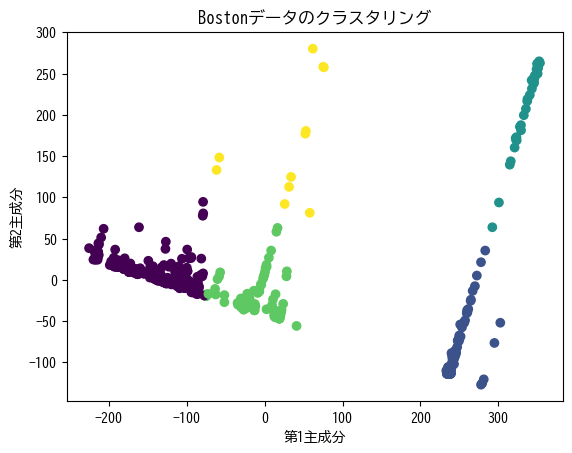

In [43]:
# Bostonデータのクラスタリング
Z = np.loadtxt("boston.txt", delimiter="\t")

k_means = KMeans(n_clusters=5)
k_means.fit(Z)
y = k_means.fit_predict(Z)  # どこのクラスタか

pca.fit(Z)
W = pca.fit_transform(Z)[:, [0, 1]]  # 各nに対する第1、第2主成分

plt.scatter(W[:, 0], W[:, 1], c=y)
plt.xlabel("第1主成分")
plt.ylabel("第2主成分")
plt.title("Bostonデータのクラスタリング")
plt.show()

In [44]:
def pca_regression(X, y, m):
    """PCAを用いた回帰分析を行う関数

    Args:
        X (array): 説明変数の配列
        y (array): 目的変数の配列
        m (int): 主成分の数

    Returns:
        dict: 'theta'に主成分回帰の係数、'beta'に元の変数に対する回帰係数を格納した辞書
    """
    pca = PCA(n_components=m)
    pca.fit(X)
    Z = pca.transform(X)  # 行:n、列: 主成分
    phi = pca.components_  # 行: 主成分、列:変数
    theta = np.linalg.inv(Z.T @ Z) @ Z.T @ y
    beta = phi.T @ theta
    return {'theta': theta, 'beta': beta}

In [45]:
# データ生成
n = 100
p = 5
randn = np.random.randn
X = randn(n, p)
X -= np.average(X, 0)

y = X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3] + X[:, 4] + randn(n)
y -= np.mean(y)
pca_regression(X, y, 3)

{'theta': array([ 1.41147247, -1.05012692, -0.96594818]),
 'beta': array([0.68962416, 1.26520423, 0.18769979, 1.00287455, 0.95434018])}

In [46]:
# PCA回帰での係数推定
pca_regression(X, y, 5)['beta']

array([0.96332082, 0.9060965 , 1.0104121 , 0.98216722, 1.09259351])

In [47]:
# 通常の線形回帰での係数推定
np.linalg.inv(X.T @ X) @ X.T @ y

array([0.96332082, 0.9060965 , 1.0104121 , 0.98216722, 1.09259351])